In [1]:
# sciencey preamble
%matplotlib inline
import numpy as np
import seaborn
seaborn.set(rc={"figure.figsize": (15, 6)})

def matshow(mat, **kwargs):
    seaborn.heatmap(mat, square=True, xticklabels=50, yticklabels=50, **kwargs)

In [2]:
from conceptnet_retrofitting.loaders import *
from conceptnet_retrofitting.word_vectors import WordVectors
from conceptnet_retrofitting.builders.build_assoc import build_relations_from_conceptnet
from conceptnet_retrofitting.builders.label_set import LabelSet
from sklearn.preprocessing import normalize

/home/rspeer/.virtualenvs/lum3/lib/python3.5/site-packages/scikit_learn-0.16.1-py3.5-linux-x86_64.egg/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [3]:
PATH = '../build-data/'

In [4]:
labels = LabelSet(load_labels(PATH + 'glove.840B.300d.standardized.conceptnet5.labels'))
sparse_rels = build_relations_from_conceptnet(labels, '/wobbly/data/conceptnet5/assoc/reduced.csv')

In [58]:
cnglove = load_word_vectors(PATH + 'glove.840B.300d.standardized.conceptnet5.labels', PATH + 'glove.840B.300d.l1.standardized.conceptnet5.npy', PATH + 'wl1-replacements.msgpack')
# glove = load_word_vectors(PATH + 'glove.840B.300d.standardized.labels', PATH + 'glove.840B.300d.l1.standardized.npy')

In [7]:
from conceptnet_retrofitting.builders.retrofit import dense_relation_array

In [74]:
rel_array = dense_relation_array(cnglove.vectors[:100000], {rel: sp[:100000, :100000] for (rel, sp) in sparse_rels.items()})

/home/rspeer/.virtualenvs/lum3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


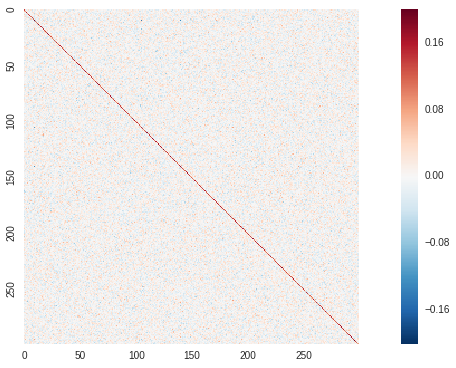

In [75]:
matshow(rel_array[-1])

In [11]:
def en_filter(term):
    return term.startswith('/c/en/')

In [13]:
rel_labels = sorted(sparse_rels)

In [14]:
def read_analogies(filename):
    for line in open(filename, encoding='utf-8'):
        line = line.rstrip()
        if not line or line.startswith('#'):
            continue
        parts = line.split('\t')
        inputs = parts[1:4]
        answers = parts[4:]
        yield inputs, answers

In [76]:
sym_rel_array = np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0)

In [77]:
any_rel = np.mean(cnglove.vectors, 0) @ sym_rel_array @ np.mean(cnglove.vectors, 0)

In [99]:
def which_relation(wv, rar, c1, c2):
    rels = wv.to_vector(c2) @ rar @ wv.to_vector(c1)
    diff = np.maximum(0, rels - any_rel) ** 2
    diff /= np.sum(diff)
    return diff

In [65]:
def rank3_inner_product(vec, array3):
    return (array3 * vec[:, np.newaxis, np.newaxis]).sum(0)

In [85]:
def eval_analogy(wv, rel_array, c1, c2, c3, c4):
    if c4 in (c1, c2, c3):
        return 0.
    rar = np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0)
    try:
        relA = which_relation(wv, rar, c1, c2)
        relB = which_relation(wv, rar, c1, c3)
        relAr = rank3_inner_product(relA, rar)
        relBr = rank3_inner_product(relB, rar)
        v1, v2, v3, v4 = [wv.to_vector(c) for c in (c1, c2, c3, c4)]
        numer1 = v4 @ relAr @ v3 + 1
        numer2 = v4 @ relBr @ v2 + 1
        denom1 = v4 @ relAr @ v1 + 1
        denom2 = v4 @ relBr @ v1 + 1
    except KeyError:
        return 0.
    return (numer1 ** 2 * numer2) / (denom1 + denom2)


In [86]:
def analogy(wv, rel_array, c1, c2, c3, num=20):
    rar = np.concatenate([rel_array, rel_array.swapaxes(1, 2)], axis=0)

    relA = which_relation(wv, rar, c1, c2)
    relB = which_relation(wv, rar, c1, c3)
    print("RelA")
    for label, strength in zip(rel_labels + rel_labels, relA):
        print('\t%-20s\t% 7.1f' % (label, strength * 1000))
    print("RelB")
    for label, strength in zip(rel_labels + rel_labels, relB):
        print('\t%-20s\t% 7.1f' % (label, strength * 1000))
    relAr = rank3_inner_product(relA, rar)
    relBr = rank3_inner_product(relB, rar)
    v1, v2, v3 = [wv.to_vector(c) for c in (c1, c2, c3)]
    numer1 = wv.vectors @ (relAr @ v3) + 1
    numer2 = wv.vectors @ (relBr @ v2) + 1
    denom1 = wv.vectors @ (relAr @ v1) + 1
    denom2 = wv.vectors @ (relBr @ v1) + 1
    ratings = (numer1 ** 2 * numer2) / (denom1 + denom2)
    sortorder = np.argsort(-ratings)
    found = []
    for idx in sortorder:
        label = wv.labels[idx]
        if en_filter(label):
            found.append((label, ratings[idx]))
        if len(found) >= num:
            break
    return found

In [100]:
analogy(cnglove, rel_array, 'dirt', 'brown', 'leaves', num=50)

RelA
	/r/Antonym          	   93.8
	/r/AtLocation       	   47.9
	/r/Causes           	   36.3
	/r/CausesDesire     	    0.5
	/r/HasProperty      	   27.4
	/r/HasSubevent      	   30.0
	/r/IsA              	   45.0
	/r/PartOf           	   23.1
	/r/RelatedTo        	   14.2
	/r/UsedFor          	   44.2
	/r/Antonym          	   93.8
	/r/AtLocation       	   22.9
	/r/Causes           	   69.9
	/r/CausesDesire     	   18.0
	/r/HasProperty      	  339.5
	/r/HasSubevent      	   22.1
	/r/IsA              	   15.9
	/r/PartOf           	   30.4
	/r/RelatedTo        	   14.2
	/r/UsedFor          	   11.0
RelB
	/r/Antonym          	   19.2
	/r/AtLocation       	   55.5
	/r/Causes           	   38.3
	/r/CausesDesire     	   30.0
	/r/HasProperty      	   48.2
	/r/HasSubevent      	   30.7
	/r/IsA              	   47.9
	/r/PartOf           	   39.2
	/r/RelatedTo        	  127.4
	/r/UsedFor          	   59.5
	/r/Antonym          	   19.2
	/r/AtLocation       	   49.9
	/r/Causes           	   42.2


[('/c/en/prohibition_sign', 0.82205322339911135),
 ('/c/en/overleave', 0.81531377239748426),
 ('/c/en/my_shirt', 0.81250549328815058),
 ('/c/en/brown', 0.80794284176683384),
 ('/c/en/leave', 0.80679323963493599),
 ('/c/en/embrown', 0.79692566125694997),
 ('/c/en/red_leave', 0.7968587344054362),
 ('/c/en/gridelin', 0.79414125788614798),
 ('/c/en/sinistrocular', 0.79377754206495388),
 ('/c/en/become_pale', 0.79363567734854346),
 ('/c/en/ink_in_pen', 0.79105440574921249),
 ('/c/en/compassionate_leave', 0.7897480997238927),
 ('/c/en/sinistrorse', 0.78901767247008769),
 ('/c/en/blue/neg', 0.78794850504813319),
 ('/c/en/complementary_color', 0.78628342378227312),
 ('/c/en/reddishly', 0.78626578519525825),
 ('/c/en/right/neg', 0.78495974878590957),
 ('/c/en/most_plant', 0.78480664086726271),
 ('/c/en/eumelanic', 0.78469083059773737),
 ('/c/en/turn_pale', 0.78451825736490111),
 ('/c/en/dark_indigo', 0.78401788731444311),
 ('/c/en/brown/neg', 0.78207910932691915),
 ('/c/en/melanonychia', 0.7809

In [24]:
def analogy_3cosmul(wv, c1, c2, c3, num=20):
    sims1 = (wv.vectors @ wv.to_vector(c1)) + 1.000001
    sims2 = (wv.vectors @ wv.to_vector(c2)) + 1
    sims3 = (wv.vectors @ wv.to_vector(c3)) + 1
    ratings = sims2 * sims3 / (sims1)
    sortorder = np.argsort(-ratings)
    found = []
    for idx in sortorder:
        label = wv.labels[idx]
        if en_filter(label):
            found.append((label, ratings[idx]))
        if len(found) >= num:
            break
    return found


In [42]:
def eval_analogy_3cosmul(wv, c1, c2, c3, c4):
    try:
        v4 = wv.to_vector(c4)
        sim1 = v4 @ wv.to_vector(c1) + 1.000001
        sim2 = v4 @ wv.to_vector(c2) + 1
        sim3 = v4 @ wv.to_vector(c3) + 1
    except KeyError:
        return 0.
    return sim2 * (sim3 ** 3) / sim1

In [26]:
def eval_analogies(analogy_func, filename='/nfs/broadway/data/corpora/readtheory-analogies.txt'):
    total = 0
    correct = 0
    for inputs, answers in read_analogies(filename):
        # The 'inputs' are the three given components of the analogy.
        # 'answers' are the multiple-choice answers, where the correct answer is first in the list.
        best_score = 0.
        best_answer = ''
        for answer in answers:
            quad = inputs + [answer]
            score = analogy_func(*quad)
            if score >= best_score:
                best_score = score
                best_answer = answer
        total += 1
        if best_answer == answers[0]:
            correct += 1
        else:
            items = tuple(inputs + [best_answer.upper()] + [answers[0].upper()])
            print("%s : %s :: %s : %s (should be %s)" % items)
    print("Score: %2.2f%% (%d/%d)" % (correct / total * 100, correct, total))
    return correct / total

In [69]:
def curry_3cosmul(c1, c2, c3, c4):
    return eval_analogy_3cosmul(cnglove, c1, c2, c3, c4)

In [70]:
def curry_inferred(c1, c2, c3, c4):
    return eval_analogy(cnglove, rel_array, c1, c2, c3, c4)

In [96]:
print('\n3cosmul:')
eval_analogies(curry_3cosmul)
print('\ninferred relations:')
eval_analogies(curry_inferred)

print('\n3cosmul:')
eval_analogies(curry_3cosmul, filename='/nfs/broadway/data/corpora/learningexpress-analogies.txt')
print('\ninferred relations:')
eval_analogies(curry_inferred, filename='/nfs/broadway/data/corpora/learningexpress-analogies.txt')


3cosmul:
dirt : brown :: leaves : GRAY (should be GREEN)
shoes : feet :: helmet : ARMS (should be HEAD)
poor : money :: sad : FEELINGS (should be HAPPINESS)
now : later :: easy : SIMPLE (should be DIFFICULT)
lettuce : green :: strawberry : ORANGE (should be RED)
Score: 94.57% (87/92)

inferred relations:
dirt : brown :: leaves : PURPLE (should be GREEN)
shoes : feet :: helmet : ARMS (should be HEAD)
guitar : instrument :: sofa : BED (should be FURNITURE)
chess : game :: lipstick : LIP (should be MAKEUP)
lettuce : green :: strawberry : ORANGE (should be RED)
spend : save :: give : ASK (should be RECEIVE)
Score: 93.48% (86/92)

3cosmul:
train : board :: horse : RIDE (should be MOUNT)
hair : coif :: musical : PRAISE (should be SCORE)
fetish : fixation :: slight : CONFUSE (should be INSULT)
obscene : coarse :: obtuse : OBSCURE (should be STUPID)
diamond : baseball :: court : JURY (should be SQUASH)
smear : libel :: heed : DOUBT (should be CONSIDER)
marshal : prisoner :: principal : TEACHE

0.7567567567567568